<a href="https://colab.research.google.com/github/deagwon97/algorithm/blob/master/notebook/train/%5BHK%5Dsam_UetEffb7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.display import clear_output
!pip install segmentation_models_pytorch
!pip install albumentations==0.3.2
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir # albu.lambda 지원을 위해 설치
!pip install wandb
clear_output()

In [ ]:
from PIL import Image
import tifffile as tiff
import subprocess
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt
import sys
import numpy as np
import cv2
import os
from tqdm import tqdm as tqdm
import random
import zipfile
from sklearn.model_selection import train_test_split
from collections import defaultdict
import wandb
import math
import torchvision
import torchvision.transforms as transforms
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.optimizer import Optimizer
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

import albumentations as albu
#from albumentations import torch as AT
from albumentations import Compose,Resize,OneOf,RandomBrightness,RandomContrast,Normalize,HorizontalFlip,Blur,ElasticTransform,GridDistortion,OpticalDistortion,GaussNoise 
from albumentations.pytorch import ToTensor
import segmentation_models_pytorch as smp
train_meta = pd.read_csv('/content/drive/MyDrive/kaggledrive/kidney/new_data/train.csv').set_index('id')

seed = 1015
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
if not os.path.exists("train_object_512"):
    !mkdir /content/train_object_512
    !mkdir /content/masks_object_512

    path = "/content/drive/MyDrive/kaggledrive/kidney/slide_data/"
    !cp "{path}train_object_512.zip" "/content/train_object_512/train_object.zip"
    !cp "{path}masks_object_512.zip" "/content/masks_object_512/masks_object.zip "

    !unzip "/content/train_object_512/train_object.zip"  -d "/content/train_object_512"
    !unzip "/content/masks_object_512/masks_object.zip " -d "/content/masks_object_512"

    clear_output()

In [ ]:
class Kidney_Dataset(torch.utils.data.Dataset):
    def __init__(self, namelist, 
                 transform=None,
                 preprocessing=None,
                 classes=1, 
                 augmentation=None, 
                ):
        self.namelist = namelist
        self.transforms = transform
        self.classes = classes
        self.preprocessing = preprocessing
        self.augmentation = augmentation
        self.imgsize = 512

        self.to_tensor = Compose([
                                  albu.Lambda(image= to_tensor, mask=to_tensor),
                               ])
        
        
    def __getitem__(self,index):
        img_name = self.namelist[index]
        # Read Data----------------------------------------
        img = np.array(Image.open("train_object_512/"+img_name))
        mask = np.array(Image.open("masks_object_512/"+img_name))[...,np.newaxis]

        #apply augmentation
        if self.augmentation:
            sample = self.augmentation(image=img, mask=mask)
            img, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=img, mask=mask)
            img, mask = sample['image'], sample['mask']

        # reshape for converting to tensor (모두 적용)
        sample = self.to_tensor(image=img, mask=mask)
        img, mask = sample['image'], sample['mask']
        
        return img/255, mask
    
    def __len__(self):
        return len(self.namelist)

In [ ]:
def get_training_augmentation():
    transform = [
        albu.Transpose(p=0.5),   # 2배
        albu.RandomRotate90(3),  # 4배
        albu.ShiftScaleRotate(p = 1),
        albu.ColorJitter(p = 0.8),
        #albu.CLAHE(p = 0.5),
        #albu.RandomSizedCrop(min_max_height=(384, 512), height = 512, width = 512, p = 1),#(128,256)사이에서 랜덤하게 크롭하고 회전
        albu.GridDistortion(p = 0.2), # 2배
        albu.GridDropout(p=0.5, ratio = 0.3),
        ]
    return albu.Compose(transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image = preprocessing_fn),
    ]
    return albu.Compose(_transform)

In [ ]:
namelist = []
with zipfile.ZipFile("/content/train_object_512/train_object.zip", 'r') as img_arch:
    namelist = img_arch.namelist().copy()
len(namelist)

6391

In [ ]:
dataset = Kidney_Dataset(namelist, augmentation = get_training_augmentation(),  classes=1)

In [ ]:
img_id = 2

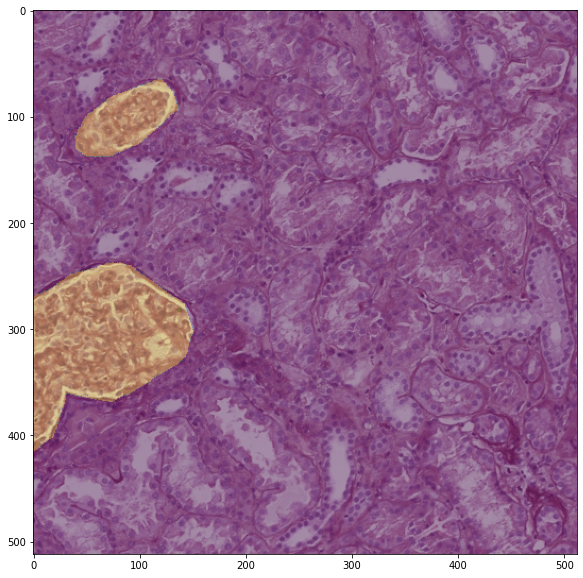

In [ ]:
#img_id = 15 +img_id
plt.figure(figsize=(10,10))
img, mask = dataset[img_id]
plt.imshow(img.transpose([1,2,0])) # 원본 # permute는 축 변경
plt.imshow(mask[0,:,:], alpha=0.3) # 레이블
plt.show()

In [ ]:
import torch


class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None: continue
                e_w = p.grad * scale
                p.add_(e_w)  # climb to the local maximum "w + e(w)"
                self.state[p]["e_w"] = e_w

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.sub_(self.state[p]["e_w"])  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad: self.zero_grad()

    def step(self, closure=None):
        raise NotImplementedError("SAM doesn't work like the other optimizers, you should first call `first_step` and the `second_step`; see the documentation for more info.")

    def _grad_norm(self):
        norm = torch.norm(
                    torch.stack([
                        p.grad.norm(p=2)
                        for group in self.param_groups for p in group["params"]
                        if p.grad is not None
                    ]),
                    p=2
               )
        return norm


class Lookahead(Optimizer):
    def __init__(self, base_optimizer, alpha=0.5, k=6):
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        defaults = dict(lookahead_alpha=alpha, lookahead_k=k, lookahead_step=0)
        self.base_optimizer = base_optimizer
        self.param_groups = self.base_optimizer.param_groups
        self.defaults = base_optimizer.defaults
        self.defaults.update(defaults)
        self.state = defaultdict(dict)
        # manually add our defaults to the param groups
        for name, default in defaults.items():
            for group in self.param_groups:
                group.setdefault(name, default)

    def update_slow(self, group):
        for fast_p in group["params"]:
            if fast_p.grad is None:
                continue
            param_state = self.state[fast_p]
            if 'slow_buffer' not in param_state:
                param_state['slow_buffer'] = torch.empty_like(fast_p.data)
                param_state['slow_buffer'].copy_(fast_p.data)
            slow = param_state['slow_buffer']
            slow.add_(group['lookahead_alpha'], fast_p.data - slow)
            fast_p.data.copy_(slow)

    def sync_lookahead(self):
        for group in self.param_groups:
            self.update_slow(group)

    def step(self, closure=None):
        # print(self.k)
        #assert id(self.param_groups) == id(self.base_optimizer.param_groups)
        loss = self.base_optimizer.step(closure)
        for group in self.param_groups:
            group['lookahead_step'] += 1
            if group['lookahead_step'] % group['lookahead_k'] == 0:
                self.update_slow(group)
        return loss

    def state_dict(self):
        fast_state_dict = self.base_optimizer.state_dict()
        slow_state = {
            (id(k) if isinstance(k, torch.Tensor) else k): v
            for k, v in self.state.items()
        }
        fast_state = fast_state_dict['state']
        param_groups = fast_state_dict['param_groups']
        return {
            'state': fast_state,
            'slow_state': slow_state,
            'param_groups': param_groups,
        }

    def load_state_dict(self, state_dict):
        fast_state_dict = {
            'state': state_dict['state'],
            'param_groups': state_dict['param_groups'],
        }
        self.base_optimizer.load_state_dict(fast_state_dict)

        # We want to restore the slow state, but share param_groups reference
        # with base_optimizer. This is a bit redundant but least code
        slow_state_new = False
        if 'slow_state' not in state_dict:
            print('Loading state_dict from optimizer without Lookahead applied.')
            state_dict['slow_state'] = defaultdict(dict)
            slow_state_new = True
        slow_state_dict = {
            'state': state_dict['slow_state'],
            'param_groups': state_dict['param_groups'],  # this is pointless but saves code
        }
        super(Lookahead, self).load_state_dict(slow_state_dict)
        self.param_groups = self.base_optimizer.param_groups  # make both ref same container
        if slow_state_new:
            # reapply defaults to catch missing lookahead specific ones
            for name, default in self.defaults.items():
                for group in self.param_groups:
                    group.setdefault(name, default)
                    
class Ralamb(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(Ralamb, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Ralamb, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('Ralamb does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                # Decay the first and second moment running average coefficient
                # m_t
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                # v_t
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]

                if state['step'] == buffered[0]:
                    N_sma, radam_step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        radam_step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        radam_step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = radam_step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                radam_step = p_data_fp32.clone()
                if N_sma >= 5:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    radam_step.addcdiv_(-radam_step_size * group['lr'], exp_avg, denom)
                else:
                    radam_step.add_(-radam_step_size * group['lr'], exp_avg)

                radam_norm = radam_step.pow(2).sum().sqrt()
                weight_norm = p.data.pow(2).sum().sqrt().clamp(0, 10)
                if weight_norm == 0 or radam_norm == 0:
                    trust_ratio = 1
                else:
                    trust_ratio = weight_norm / radam_norm

                state['weight_norm'] = weight_norm
                state['adam_norm'] = radam_norm
                state['trust_ratio'] = trust_ratio

                if N_sma >= 5:
                    p_data_fp32.addcdiv_(-radam_step_size * group['lr'] * trust_ratio, exp_avg, denom)
                else:
                    p_data_fp32.add_(-radam_step_size * group['lr'] * trust_ratio, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss


def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 0
seed_everything(SEED)

In [ ]:
class DiceScore(smp.utils.base.Metric):
    __name__ = 'dice_score'

    def __init__(self, eps=1e-7, threshold=0.5, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.threshold = threshold
        #self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = smp.utils.functional._threshold(y_pr, threshold=self.threshold)
        y_pr, y_gt = smp.utils.functional._take_channels(y_pr, y_gt, ignore_channels=self.ignore_channels)
        tp = torch.sum(y_gt * y_pr)
        total = torch.sum(y_gt) + torch.sum(y_pr)
        score = (tp + self.eps) * 2 / (total + self.eps)
        return score

class SamTrainEpoch(smp.utils.train.TrainEpoch):
    def __init__(self, model, loss, metrics, optimizer, device='cuda', verbose=True):
        super().__init__(
            model = model,
            loss = loss,
            metrics = metrics,
            optimizer = optimizer,
            device = device,
            verbose = verbose
        )

    def batch_update(self, x, y):
        self.optimizer.zero_grad()
        prediction = self.model.forward(x)

        #
        loss = self.loss(prediction, y)
        loss.backward()
        optimizer.first_step(zero_grad=True)

        self.loss(self.model.forward(x), y).backward()
        optimizer.second_step(zero_grad=True)

        return loss, prediction

    def run(self, dataloader):

        self.on_epoch_start()

        logs = {}
        loss_meter = smp.utils.meter.AverageValueMeter()
        metrics_meters = {metric.__name__: smp.utils.meter.AverageValueMeter() for metric in self.metrics}

        with tqdm(dataloader, desc=self.stage_name, file=sys.stdout, disable=not (self.verbose)) as iterator:
            
            for x, y in iterator:
                x, y = x.to(self.device), y.to(self.device)
                loss, y_pred = self.batch_update(x, y)

                # update loss logs
                loss_value = loss.cpu().detach().numpy()
                loss_meter.add(loss_value)
                loss_logs = {self.loss.__name__: loss_meter.mean}
                logs.update(loss_logs)

                # update metrics logs
                for metric_fn in self.metrics:
                    metric_value = metric_fn(y_pred, y).cpu().detach().numpy()
                    metrics_meters[metric_fn.__name__].add(metric_value)
                metrics_logs = {k: v.mean for k, v in metrics_meters.items()}
                logs.update(metrics_logs)

                new_logs = {}
                for key in logs.keys():
                    new_logs['train_'+key] = logs[key]
                wandb.log(new_logs)

                if self.verbose:
                    s = self._format_logs(logs)
                    iterator.set_postfix_str(s)
        return logs

In [ ]:
namelist = []
with zipfile.ZipFile("/content/train_object_512/train_object.zip", 'r') as img_arch:
    namelist = img_arch.namelist().copy()
    
len(namelist)
namelist = np.array(namelist)

In [ ]:
# model save path

path = '/content/drive/MyDrive/kaggledrive/kidney/model/sam_uneteb7/'


In [ ]:
import wandb
!wandb login
# 04e6d67fe4bcbf0d12c5ec8957027496271c0245
wandb.init(project="hubmap_kidney", reinit = True)
wandb.run.name = 'sam'
# generted run ID로 하고 싶다면 다음과 같이 쓴다.
# wandb.run.name = wandb.run.id
wandb.run.save()

wandb: Currently logged in as: deagwon-bu (use `wandb login --relogin` to force relogin)


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


True

In [ ]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

train_names, test_names = train_test_split(namelist, test_size=0.1,random_state=1015)

target_fold_index = 1
for fold_index, (trn_idx, val_idx) in enumerate(kfold.split(namelist),1):
    print(fold_index)
    if fold_index == target_fold_index:
        train_names, test_names = namelist[trn_idx], namelist[val_idx]

        ENCODER = 'efficientnet-b7'
        ENCODER_WEIGHTS = 'imagenet'
        DEVICE = 'cuda'
        ACTIVATION = 'sigmoid'

        model = smp.Unet(
                    encoder_name=ENCODER, 
                    encoder_weights=ENCODER_WEIGHTS, 
                    in_channels = 3,
                    classes=1, 
                    activation = ACTIVATION
                )
        loss = smp.utils.losses.DiceLoss()
        # 마찬가지로 mae_over_fscore의 pytorch metric version입니다.
        metrics = [ DiceScore(threshold=0.5)]
        #base_optimizer = Ralamb(model.parameters(), weight_decay=0.01)
        #optimizer = Lookahead(base_optimizer)
        base_optimizer = torch.optim.SGD
        optimizer = SAM(model.parameters(), base_optimizer, lr=0.1, momentum=0.9)

        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 10, 2,eta_min=1e-6) # 1e-6

        train_epoch = SamTrainEpoch(
            model, 
            loss=loss, 
            metrics=metrics, 
            optimizer=optimizer,
            device=DEVICE,
            verbose=True,
        )

        valid_epoch = smp.utils.train.ValidEpoch(
            model, 
            loss=loss, 
            metrics=metrics, 
            device=DEVICE,
            verbose=True,
        )

        BATCH_SIZE = 4
        train_dataset = Kidney_Dataset(train_names, augmentation = get_training_augmentation(),  classes=1)
        valid_dataset = Kidney_Dataset(test_names, classes=1)
        train_loader = DataLoader(train_dataset,  batch_size=BATCH_SIZE, shuffle=True, num_workers=4, persistent_workers = True)
        valid_loader = DataLoader(valid_dataset,  batch_size=40, shuffle=False, num_workers=2)

        loaders = {
            "train": train_loader,
            "valid": valid_loader
        }
        
        # 한 폴드당 150 Epoch 수행
        NUM_EPOCH = 50
        min_score = np.Inf
        MODEL = "UnetEB7"
        for i in range(0, NUM_EPOCH):
            print('\nEpoch: {}'.format(i))
            train_logs = train_epoch.run(train_loader)
            valid_logs = valid_epoch.run(valid_loader)

            new_logs = {}
            for key in valid_logs.keys():
                new_logs['valid_'+key] = valid_logs[key]
            wandb.log(new_logs)


            scheduler.step()
            valid_loss = valid_logs['dice_loss']
            if min_score > valid_loss:
                min_score = valid_loss
                torch.save(model, f'{path}{fold_index}_{MODEL}_{loss.__name__}_{valid_loss:2.4f}_epoch_{i}.pth')
                torch.save(model, f'{path}{fold_index}_{MODEL}_{loss.__name__}.pth')
                print('Model saved!')
        target_fold_index += 1
        break

1


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth




Epoch: 0
valid: 100%|██████████| 32/32 [00:28<00:00,  1.11it/s, dice_loss - 0.1216, dice_score - 0.8786]
Model saved!

Epoch: 1
valid: 100%|██████████| 32/32 [00:28<00:00,  1.13it/s, dice_loss - 0.1218, dice_score - 0.879]

Epoch: 2
valid: 100%|██████████| 32/32 [00:28<00:00,  1.13it/s, dice_loss - 0.1186, dice_score - 0.8815]
Model saved!

Epoch: 3
valid: 100%|██████████| 32/32 [00:28<00:00,  1.13it/s, dice_loss - 0.113, dice_score - 0.8871]
Model saved!

Epoch: 4
valid: 100%|██████████| 32/32 [00:28<00:00,  1.13it/s, dice_loss - 0.1152, dice_score - 0.8849]

Epoch: 5
valid: 100%|██████████| 32/32 [00:28<00:00,  1.13it/s, dice_loss - 0.1166, dice_score - 0.8834]

Epoch: 6
valid: 100%|██████████| 32/32 [00:28<00:00,  1.13it/s, dice_loss - 0.1109, dice_score - 0.8892]
Model saved!

Epoch: 7
valid: 100%|██████████| 32/32 [00:28<00:00,  1.13it/s, dice_loss - 0.1117, dice_score - 0.8884]

Epoch: 8
valid: 100%|██████████| 32/32 [00:28<00:00,  1.13it/s, dice_loss - 0.1106, dice_score - 0.8

In [ ]:
path

'/content/drive/MyDrive/kaggledrive/kidney/model/sam_uneteb7/'

In [ ]:
checkpoint = { 
    'epoch': i,
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'lr_sched': scheduler
}
torch.save(checkpoint, path + 'checkpoint.pth')